# Hextraj tutorial

We'll learn how to

- [x] create a projection
- [x] label positions along a trajectory
- [x] aggregate data within the labelled hexagons
- [x] calculate a connectivity matrix for the hexagons
- [x] Aggregate gridded data into hexes
- [x] Aggregate point-cloud data into hexes

## Imports

In [1]:
from hextraj import HexProj

import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from dask.distributed import Client

In [2]:
dask_client = Client(n_workers=2, threads_per_worker=2)
dask_client

2023-02-27 13:08:22,622 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-gv8p_7a4', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 7.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33327,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.77 GiB
Comm: tcp://127.0.0.1:35733,Total threads: 2
Dashboard: http://127.0.0.1:32875/status,Memory: 3.89 GiB
Nanny: tcp://127.0.0.1:38609,


## The HexProj object

By default, it uses the [Lambert Azimuthal Equal-Area Projection](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection) centered about a location `(lon_origin, lat_origin)`, which needs to be specified by the user.
It also uses a hex size in meters (which is the distance of the corners from the center of the hex), and defaults to a "flat top" orientation of the hexed.

For details, check
```python
HexProj?
```

## Load some trajectories

There's an example dataset included in the repo here. It covers the North-Sea region and has 19-day-long trajectories with one timestep / day.

In [3]:
ds_traj = xr.open_dataset("../data/trajs/nwshelf.nc", chunks={"traj": 1000, "obs": 10})
ds_traj

<xarray.Dataset>
Dimensions:      (traj: 5000, obs: 20)
Dimensions without coordinates: traj, obs
Data variables:
    time         (traj, obs) datetime64[ns] dask.array<chunksize=(1000, 10), meta=np.ndarray>
    trajectory   (traj, obs) float64 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    lon          (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    lat          (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    z            (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    temperature  (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    salinity     (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    land         (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

# A hex projector

We need a good center longitude and latitude and a good size of the hexes.
The height (North-South) of the flat hexes is $\sqrt{3}\cdot{\rm size}$.
We chose approx. 10 hexes in the meridional direction.
(This is fewer hexes than we'll want in a realistic application. But as we only have 5000 test trajectories here, we want some statistics.)

In [4]:
lon_origin = (ds_traj.lon.min() + ds_traj.lon.max()).compute().data[()] / 2
lat_origin = (ds_traj.lat.min() + ds_traj.lat.max()).compute().data[()] / 2
hex_size_meters = (
    (ds_traj.lat.max() - ds_traj.lat.min()).compute().data[()]
    * 111e3 / 10 / (3 ** 0.5)
)

print(lon_origin, "E\t", lat_origin, "N")
print(hex_size_meters, "meters")

-2.9847207069396973 E	 54.37133026123047 N
107296.83755830918 meters


In [5]:
hex_proj = HexProj(
    lon_origin=lon_origin,
    lat_origin=lat_origin,
    hex_size_meters=hex_size_meters,
)

/srv/conda/envs/notebook/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
print(hex_proj)

HexProj(projection_name='laea', lon_origin=-2.9847207069396973, lat_origin=54.37133026123047, hex_size_meters=107296.83755830918, hex_orientation='flat', )


## Hex labels for each position

We use the method `hex_proj.lon_lat_to_hex_AoS()` for labelling. This method returns an _A_rray _o_f _S_tructures where each element is a 3-element tuple `(q, r, s)` which represent [cube coords on a hexagonal grid](https://www.redblobgames.com/grids/hexagons/#coordinates-cube).

We use `xr.apply_ufunc()` for applying this method to the Xarray data arrays `lon` and `lat` in a parallelized way.

In [7]:
%%time

hex_labels = xr.apply_ufunc(
    hex_proj.lon_lat_to_hex_AoS,
    ds_traj.lon, 
    ds_traj.lat,
    dask="parallelized",
    output_dtypes=[tuple, ],
).rename("hex_labels")

# note that this does not compute anything yet, but just defines the dependencies of the desired output.

CPU times: user 2.56 ms, sys: 945 µs, total: 3.5 ms
Wall time: 3.74 ms


In [8]:
hex_labels

<xarray.DataArray 'hex_labels' (traj: 5000, obs: 20)>
dask.array<transpose, shape=(5000, 20), dtype=object, chunksize=(1000, 10), chunktype=numpy.ndarray>
Dimensions without coordinates: traj, obs

Let's add this to the trajectory dataset:

In [9]:
ds_traj["hex_labels"] = hex_labels
ds_traj

<xarray.Dataset>
Dimensions:      (traj: 5000, obs: 20)
Dimensions without coordinates: traj, obs
Data variables:
    time         (traj, obs) datetime64[ns] dask.array<chunksize=(1000, 10), meta=np.ndarray>
    trajectory   (traj, obs) float64 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    lon          (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    lat          (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    z            (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    temperature  (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    salinity     (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    land         (traj, obs) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    hex_labels   (traj, obs) object dask.array<chunksize=(1000, 10), meta=np.ndarray>
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

## Hex heat maps

The simplest way to create a heatmap now is to group by the hex labels and then count each position per group.
But `xr.DataArray.groupby()` only really works with numerical values or strings.


In [10]:
from dask import array as darr

In [11]:
%%time

# cast to numpy and chunk up again
unique_hex_labels = darr.unique(ds_traj["hex_labels"].data)
unique_hex_labels = np.sort(unique_hex_labels.compute())
print("raw label array:")
display(unique_hex_labels)
unique_hex_labels = darr.from_array(unique_hex_labels, chunks=(int(len(unique_hex_labels) // 4 + 1), ))

# to xarray
unique_hex_labels =  xr.DataArray(
    unique_hex_labels,
    dims=("unique_hex", ),
    name="unique_hex",
)

print("\nxr DataArray:")
display(unique_hex_labels)

raw label array:


array([(-9223372036854775808, -9223372036854775808, 0), (-6, -2, 8),
       (-6, -1, 7), (-6, 0, 6), (-6, 1, 5), (-6, 2, 4), (-5, -2, 7),
       (-5, -1, 6), (-5, 0, 5), (-5, 1, 4), (-5, 2, 3), (-5, 3, 2),
       (-5, 4, 1), (-5, 5, 0), (-5, 6, -1), (-4, -3, 7), (-4, -2, 6),
       (-4, -1, 5), (-4, 0, 4), (-4, 1, 3), (-4, 2, 2), (-4, 3, 1),
       (-4, 4, 0), (-4, 5, -1), (-4, 6, -2), (-4, 7, -3), (-3, -3, 6),
       (-3, -2, 5), (-3, -1, 4), (-3, 0, 3), (-3, 1, 2), (-3, 2, 1),
       (-3, 3, 0), (-3, 4, -1), (-3, 5, -2), (-3, 6, -3), (-3, 7, -4),
       (-2, -4, 6), (-2, -3, 5), (-2, -2, 4), (-2, -1, 3), (-2, 0, 2),
       (-2, 1, 1), (-2, 2, 0), (-2, 3, -1), (-2, 4, -2), (-2, 5, -3),
       (-2, 6, -4), (-1, -4, 5), (-1, -3, 4), (-1, -2, 3), (-1, -1, 2),
       (-1, 0, 1), (-1, 1, 0), (-1, 2, -1), (-1, 3, -2), (-1, 4, -3),
       (-1, 5, -4), (-1, 6, -5), (0, -5, 5), (0, -4, 4), (0, -3, 3),
       (0, -2, 2), (0, -1, 1), (0, 0, 0), (0, 1, -1), (0, 2, -2),
       (0, 3, -3), (0, 4, -


xr DataArray:


<xarray.DataArray 'unique_hex' (unique_hex: 103)>
dask.array<array, shape=(103,), dtype=object, chunksize=(26,), chunktype=numpy.ndarray>
Dimensions without coordinates: unique_hex

CPU times: user 117 ms, sys: 32.5 ms, total: 149 ms
Wall time: 640 ms


In [12]:
pos_per_hex = (ds_traj.hex_labels == unique_hex_labels).sum("traj")
pos_per_hex

<xarray.DataArray (obs: 20, unique_hex: 103)>
dask.array<sum-aggregate, shape=(20, 103), dtype=int64, chunksize=(10, 26), chunktype=numpy.ndarray>
Dimensions without coordinates: obs, unique_hex

Note that along the way, we have created a much larger but virtual array, which we never fully know at the same time, however:

In [13]:
(ds_traj.hex_labels == unique_hex_labels)

<xarray.DataArray (traj: 5000, obs: 20, unique_hex: 103)>
dask.array<eq, shape=(5000, 20, 103), dtype=bool, chunksize=(1000, 10, 26), chunktype=numpy.ndarray>
Dimensions without coordinates: traj, obs, unique_hex

In [14]:
pos_per_hex

<xarray.DataArray (obs: 20, unique_hex: 103)>
dask.array<sum-aggregate, shape=(20, 103), dtype=int64, chunksize=(10, 26), chunktype=numpy.ndarray>
Dimensions without coordinates: obs, unique_hex

Now, we need the positions of each of the unique hexes:

In [15]:
from hextraj.aux import hex_AoS_to_SoA

In [16]:
_lon, _lat = hex_proj.hex_to_lon_lat_SoA(hex_AoS_to_SoA(unique_hex_labels.data.compute()))
pos_per_hex = pos_per_hex.assign_coords(
    lon=("unique_hex", _lon),
    lat=("unique_hex", _lat),
)
pos_per_hex

<xarray.DataArray (obs: 20, unique_hex: 103)>
dask.array<sum-aggregate, shape=(20, 103), dtype=int64, chunksize=(10, 26), chunktype=numpy.ndarray>
Coordinates:
    lon      (unique_hex) float64 nan -15.32 -15.71 -16.13 ... 8.234 9.529 10.65
    lat      (unique_hex) float64 nan 45.27 46.92 48.56 ... 58.91 54.56 57.84
Dimensions without coordinates: obs, unique_hex

In [17]:
import cartopy
from matplotlib import pyplot as plt

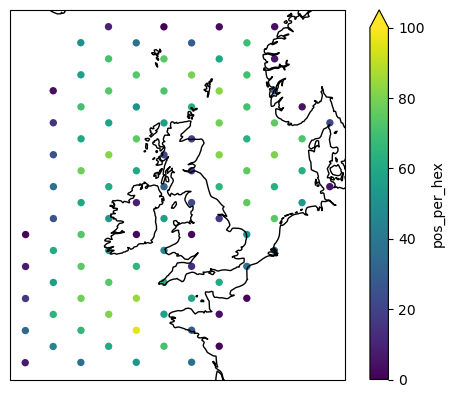

In [18]:
fig, ax = plt.subplots(1, 1, subplot_kw={
    "projection": cartopy.crs.Stereographic(
        central_latitude=hex_proj.lat_origin,
        central_longitude=hex_proj.lon_origin,
    ),
})

pos_per_hex.mean("obs").to_dataset(name="pos_per_hex").plot.scatter(
    x="lon", y="lat", hue="pos_per_hex",
    vmin=0, vmax=100,
    s=40,
    ax=ax,
    transform=cartopy.crs.PlateCarree(),
)

ax.coastlines();

## Connectivity

Let's check connectivity from the first to the last time step.

Even though we're connecting from and to the same set of hexes, we'll need to chose different names, because in the end, we want a 2d matrix:

In [19]:
unique_hex_labels_source = unique_hex_labels.rename({"unique_hex": "unique_hex_source"})
unique_hex_labels_dest = unique_hex_labels.rename({"unique_hex": "unique_hex_dest"})

In [20]:
connection_count = (
    (ds_traj.hex_labels.isel(obs=0, drop=True) == unique_hex_labels_source)
    & (ds_traj.hex_labels.isel(obs=-1, drop=True) == unique_hex_labels_dest)
).sum("traj")

display(connection_count)

<xarray.DataArray (unique_hex_source: 103, unique_hex_dest: 103)>
dask.array<sum-aggregate, shape=(103, 103), dtype=int64, chunksize=(26, 26), chunktype=numpy.ndarray>
Dimensions without coordinates: unique_hex_source, unique_hex_dest

In [21]:
%%time

connection_count = connection_count.compute()

CPU times: user 163 ms, sys: 17.7 ms, total: 181 ms
Wall time: 452 ms


_A note on computational complexity:_

```python
connection_count = (
    (ds_traj.hex_labels.isel(obs=0, drop=True) == unique_hex_labels_source)  # labelling sources
    & (ds_traj.hex_labels.isel(obs=-1, drop=True) == unique_hex_labels_dest)  # labelling destination
).sum("traj")  # aggregation
```

Here, for each pair of time steps we're interested in, labelling is proportional to `(num_traj * num_hexes * num_hexes)` and aggregation costs proportional to `(num_trajs)`.

So the calculation is easy to handle for growing numbers of trajectories, but scales infavorably for increasing hex resolution. As the number of hexes scales quadratically with the inverse of the size of the hexes, we'll see scaling of `(1/hexsize) ** 4`.

Increasing the resolution we've taken here (approx 100 kilometers) by a factor of 10 (to 10 kilometers) will increase computational cost by a factor of 10_000.  So a connectivity calculation which was done in 0.5 seconds above would take almost 2 hours (on the same ressources). As we can easily increase the resources available by a factor of 1_000, we're good tough.

In [22]:
(
    (ds_traj.hex_labels.isel(obs=0, drop=True) == unique_hex_labels_source)  # labelling sources
    & (ds_traj.hex_labels.isel(obs=-1, drop=True) == unique_hex_labels_dest)  # labelling destination
)

<xarray.DataArray (traj: 5000, unique_hex_source: 103, unique_hex_dest: 103)>
dask.array<and_, shape=(5000, 103, 103), dtype=bool, chunksize=(1000, 26, 26), chunktype=numpy.ndarray>
Dimensions without coordinates: traj, unique_hex_source, unique_hex_dest

We can look at the connectivity relative to all particles which started at a given hex:

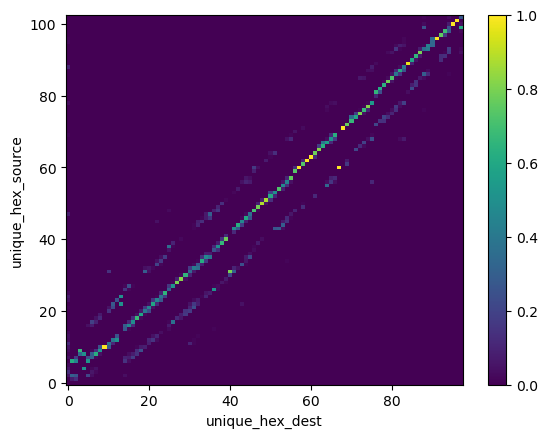

In [23]:
(connection_count / connection_count.sum("unique_hex_source")).dropna("unique_hex_dest").plot()

The connectivity is relatively local. All nonzero values are close to the diagnoal.

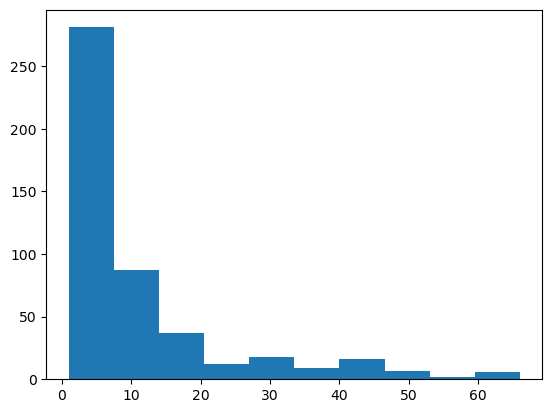

In [24]:
connection_count.where(connection_count > 0).plot.hist();

## Represent as graph

We can use the connection count to construct a directed graph.

In [25]:
import networkx

In [26]:
graph = networkx.DiGraph(connection_count.data[:, :])

The following visualisation also shows that the connectivity is primarily local. Or at least, it's possible to order the hexes in a way that there's mainly short connections.

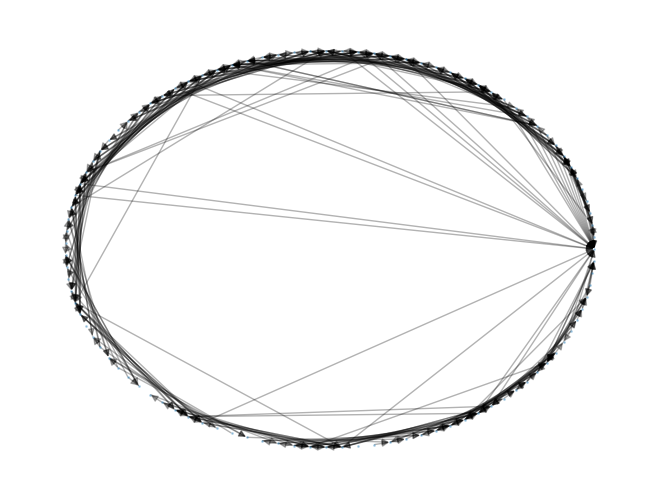

In [27]:
graph.remove_edges_from(networkx.selfloop_edges(graph))
networkx.draw_circular(graph, node_size=1, alpha=0.3)

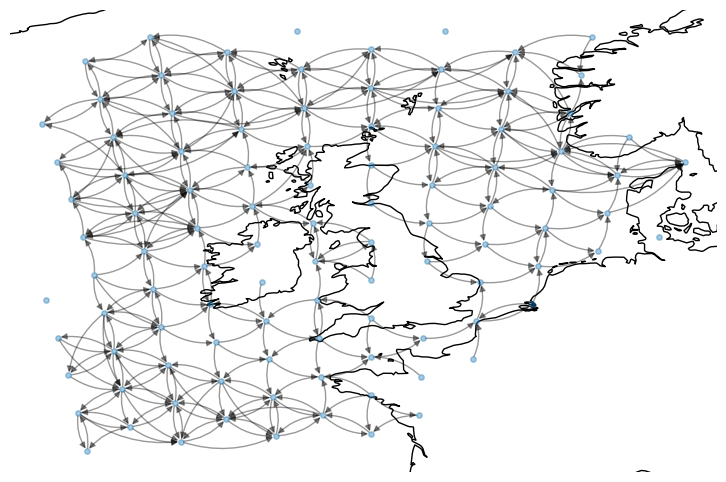

In [28]:
fig, ax = plt.subplots(
    1, 1, 
    subplot_kw={
    "projection": cartopy.crs.PlateCarree(),
    },
    figsize=(10, 6),
)

# networkx.draw_networkx_edges(
networkx.draw(
    graph, pos={n: pos for n, pos in enumerate(zip(_lon[:], _lat[:]))}, node_size=15, arrowsize=9, alpha=0.4, ax=ax,
    connectionstyle="arc3,rad=0.2"
)

ax.coastlines();

Note that this view which uses the centers of each hexagon as a node may be misleading close to the coast.

## Aggregated point-cloud data

Suppose we have some point cloud data which could, e.g., reflect habitate scores which we want to use to make more sense of.
As there currently is no such data in the repo, we make something up that covers the same region also covered by the example trajs.

In [29]:
# region coverage
lon_min, lon_max = (ds_traj.lon.min().compute().data[()], ds_traj.lon.max().compute().data[()])
lat_min, lat_max = (ds_traj.lat.min().compute().data[()], ds_traj.lat.max().compute().data[()])

# number of points
num_points = 10_000

In [30]:
def create_artificial_data_grid(
    lon_min=None, lon_max=None, lon_num=100,
    lat_min=None, lat_max=None, lat_num=100,
    num_smooth=15,
    random_seed=1234,
):
    np.random.seed(random_seed)
    lon = xr.DataArray(np.linspace(lon_min, lon_max, lon_num), dims=("lon", ), name="lon")
    lat = xr.DataArray(np.linspace(lat_min, lat_max, lat_num), dims=("lat", ), name="lat")
    
    data = xr.DataArray(
        (
            np.random.normal(size=(lon_num, lat_num))
        ),
        dims=("lon", "lat"),
        coords={"lon": lon, "lat": lat, },
        name="data",
    )
    for nsmooth in range(num_smooth):
        data = (
            data
            .rolling(lon=3, min_periods=1, center=True)
            .construct("wlon")
            .rolling(lat=3, min_periods=1, center=True)
            .construct("wlat")
            .mean(["wlon", "wlat"])
        )
    data /= data.std()

    return data


def create_artificial_data_points(
    lon_min=None, lon_max=None, lon_num_grid=100,
    lat_min=None, lat_max=None, lat_num_grid=100,
    num_smooth=15,
    num_points=1_000,
    random_seed=1234,
):
    data_grid = create_artificial_data_grid(
        lon_min=lon_min, lon_max=lon_max, lon_num=lon_num_grid,
        lat_min=lat_min, lat_max=lat_max, lat_num=lon_num_grid,
        num_smooth=num_smooth,
        random_seed=random_seed,
    )
    
    np.random.seed(random_seed)
    lon = xr.DataArray(np.random.uniform(lon_min, lon_max, size=(num_points, )), dims=("point", ), name="lon")
    lat = xr.DataArray(np.random.uniform(lat_min, lat_max, size=(num_points, )), dims=("point", ), name="lat")
    data = data_grid.sel(lon=lon, lat=lat, method="nearest")
    data = data.assign_coords(
        lon=lon, lat=lat
    )
    
    return data

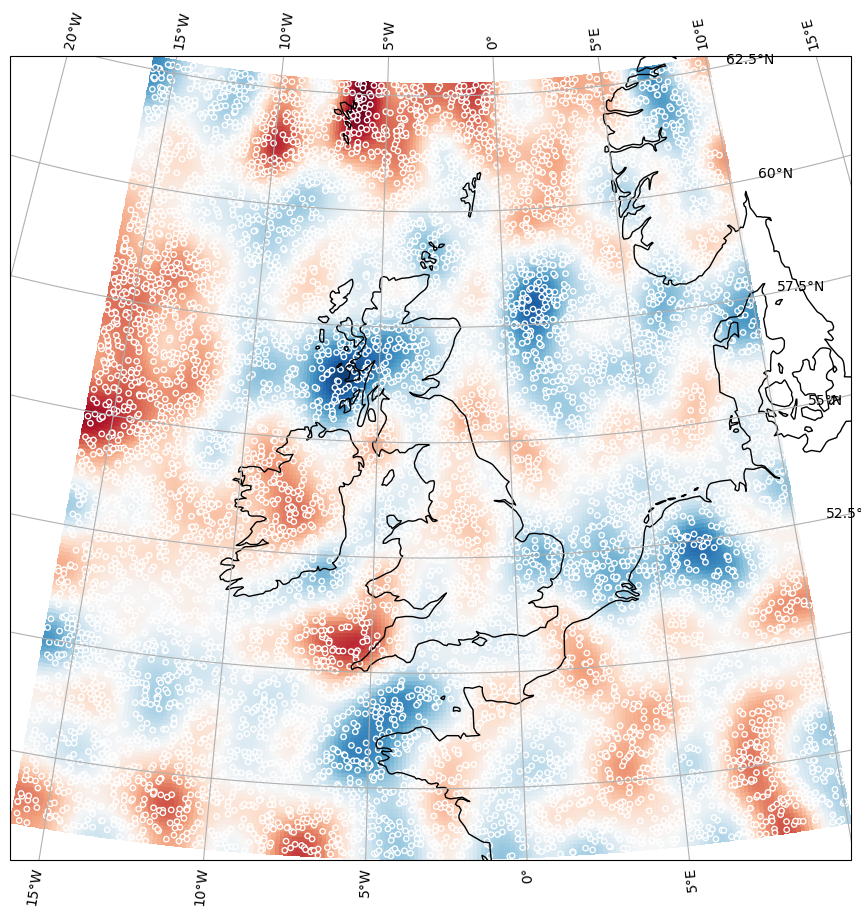

In [31]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Stereographic(
        central_longitude=lon_origin, central_latitude=lat_origin,
    )},
    figsize=(9, 9),
)

data_grid = create_artificial_data_grid(
    lon_min=lon_min, lon_max=lon_max, lon_num=200,
    lat_min=lat_min, lat_max=lat_max, lat_num=200,
    num_smooth=60,
)
data_grid.plot(
    x="lon", y="lat", ax=ax, transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
)

data_points = create_artificial_data_points(
    lon_min=lon_min, lon_max=lon_max, lon_num_grid=200,
    lat_min=lat_min, lat_max=lat_max, lat_num_grid=200,
    num_smooth=60,
    num_points=10_000,
)
data_points.to_dataset().plot.scatter(
    x="lon", y="lat", hue="data", s=15,
    ax=ax, transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
)

ax.gridlines(draw_labels=True)            
ax.coastlines()

fig.tight_layout();

So we have gridded and point data which represent the same field.

Now, let's aggregate them into the hexes.

### Aggregating gridded data

Find labels:

In [32]:
data_grid["hex_labels"] = xr.apply_ufunc(
    hex_proj.lon_lat_to_hex_AoS,
    *xr.broadcast(data_grid.lon, data_grid.lat),
).rename("hex_labels")

data_grid

<xarray.DataArray 'data' (lon: 200, lat: 200)>
array([[ 1.46498809,  1.49111488,  1.55222197, ..., -2.29274148,
        -2.30316205, -2.30695387],
       [ 1.46509485,  1.4909586 ,  1.55142366, ..., -2.2715113 ,
        -2.28215976, -2.28604652],
       [ 1.46390506,  1.48913544,  1.54805571, ..., -2.219553  ,
        -2.23073817, -2.23484873],
       ...,
       [-0.85490514, -0.86930539, -0.9033217 , ...,  1.10773454,
         1.17719558,  1.20583393],
       [-0.97158622, -0.98455417, -1.01502923, ...,  1.13677833,
         1.20517768,  1.2333728 ],
       [-1.0191267 , -1.03149721, -1.06049572, ...,  1.14793604,
         1.21588365,  1.24389034]])
Coordinates:
  * lon         (lon) float64 -16.0 -15.87 -15.74 -15.61 ... 9.769 9.899 10.03
  * lat         (lat) float64 46.0 46.08 46.17 46.25 ... 62.49 62.57 62.66 62.74
    hex_labels  (lon, lat) object (-6, -2, 8) (-6, -1, 7) ... (4, 3, -7)

Group into hexes and average field:

_(Note that we might want to apply different stats than `.mean()` here.)_

In [33]:
data_grid_agg = data_grid.groupby("hex_labels").mean()

hex_lon, hex_lat = hex_proj.hex_to_lon_lat_SoA(hex_AoS_to_SoA(
    data_grid_agg.hex_labels.data
))

data_grid_agg = data_grid_agg.assign_coords(
    lon=("hex_labels", hex_lon), lat=("hex_labels", hex_lat),
)

data_grid_agg    

<xarray.DataArray 'data' (hex_labels: 127)>
array([ 1.29480841,  0.94763667, -0.07385896, -1.40319389,  1.00555069,
        0.15614706, -0.16962952, -0.25186463,  0.30453839, -0.02041226,
        2.04702443,  1.84270274,  1.87521231,  1.12924076,  1.21800493,
        1.15418502, -0.67106372, -0.15265525,  0.47165313,  0.55892163,
        1.56993953,  1.4009226 ,  0.99053819,  0.35825403, -0.98851575,
        0.41905607, -0.08489924, -0.21919236,  0.05258601,  0.82165356,
       -0.07972565, -0.00336839,  0.07877715, -0.28203314, -0.20489151,
       -0.84694581,  1.69265944, -0.07433852, -0.20809691,  0.56765963,
        0.30899192,  1.07419403, -1.23912262, -0.28291611, -0.49092342,
        0.76985985,  0.80589866, -0.47544124, -1.91651884,  0.91590438,
        0.44504869, -0.05561396, -0.08567391, -2.24838653, -0.19187212,
        0.27609522,  2.29143213,  2.76406022, -0.22725543,  0.25299579,
       -1.11619406, -0.17002098,  0.20232926,  0.07359254, -0.42675107,
       -0.59550142, -0.7656684 ,  0.47477998,  1.80044823, -0.51519338,
        0.07982594, -0.02136968, -0.16901084,  0.15072875,  0.65106605,
       -0.60709745, -0.57532631,  0.38306763,  1.08146868,  1.0796471 ,
       -0.40834257, -0.06478021,  0.32766344,  0.39666221, -1.14953168,
        0.18912076, -0.95844421, -1.31885448,  0.13973543,  0.75134915,
        0.98071911,  0.39152963,  1.04161036,  0.46097158, -1.17407428,
       -0.74471345,  0.20089099, -0.82752872, -0.29205122, -0.39349884,
       -0.28589346, -1.00029729, -0.4436718 , -0.11169356,  0.2348403 ,
        0.06838937, -1.86977795, -0.23746494,  0.38140867, -0.95235728,
        0.04984861, -0.08546857, -0.51676882,  1.19159252,  1.04129727,
        0.29386755,  0.20868028, -0.38201456, -0.41269483, -0.6526851 ,
       -1.33352016,  0.43051397,  0.1686162 , -0.62653484, -0.19114148,
        0.69624938,  0.32078422])
Coordinates:
  * hex_labels  (hex_labels) object (-6, -2, 8) (-6, -1, 7) ... (6, -4, -2)
    lon         (hex_labels) float64 -15.32 -15.71 -16.13 ... 10.16 10.62 11.13
    lat         (hex_labels) float64 45.27 46.92 48.56 50.2 ... 48.56 50.2 51.84

Take a look

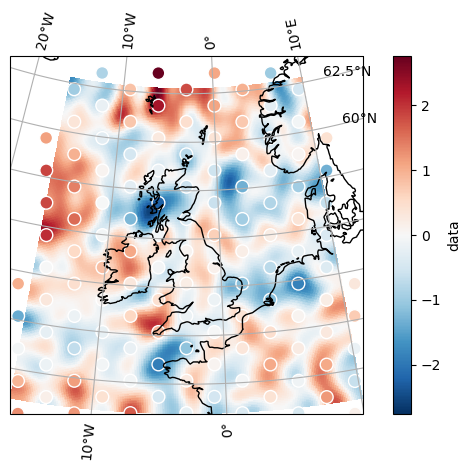

In [34]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": cartopy.crs.Stereographic(
    central_longitude=lon_origin, central_latitude=lat_origin,
)})

data_grid.plot(
    x="lon", y="lat", ax=ax, transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
)

data_grid_agg.rename("data").to_dataset().plot.scatter(
    x="lon", y="lat", hue="data", s=85,
    ax=ax, transform=cartopy.crs.PlateCarree(),
)

ax.gridlines(draw_labels=True)            
ax.coastlines()

fig.tight_layout();

### Aggregating point data

Find labels:

In [35]:
data_points["hex_labels"] = xr.apply_ufunc(
    hex_proj.lon_lat_to_hex_AoS,
    data_points.lon, 
    data_points.lat,
).rename("hex_labels")

data_points

<xarray.DataArray 'data' (point: 10000)>
array([-0.15611816,  0.29374462, -2.22455085, ..., -1.21951742,
        0.9063131 , -0.65582133])
Coordinates:
    lon         (point) float64 -11.01 0.1938 -4.606 ... -12.19 2.368 5.888
    lat         (point) float64 58.0 55.61 57.22 58.64 ... 62.49 62.56 59.59
    hex_labels  (point) object (-3, 4, -1) (1, 0, -1) ... (2, 4, -6) (3, 2, -5)
Dimensions without coordinates: point

Add hex centres:

In [36]:
data_points_agg = data_points.groupby("hex_labels").mean()

hex_lon, hex_lat = hex_proj.hex_to_lon_lat_SoA(hex_AoS_to_SoA(
    data_points_agg.hex_labels.data
))

data_points_agg = data_points_agg.assign_coords(
    lon=("hex_labels", hex_lon), lat=("hex_labels", hex_lat),
)

data_points_agg    

<xarray.DataArray 'data' (hex_labels: 127)>
array([ 1.47355149,  0.95651748, -0.00446601, -1.32832274,  1.3092648 ,
        0.24654806, -0.16192564, -0.29727246,  0.27393813, -0.01800808,
        1.96929007,  1.8185502 ,  1.88505572,  1.1446929 ,  1.20247953,
        1.10673913, -0.66226947, -0.17206721,  0.46379335,  0.52310269,
        1.53310222,  1.4229979 ,  1.04368266,  0.35446302, -0.97802086,
        0.43961611, -0.09999974, -0.18525143,  0.02896164,  0.85505011,
       -0.11162429,  0.10278446,  0.14456073, -0.2366395 , -0.201782  ,
       -0.92215739,  1.5812308 , -0.02410873, -0.18894372,  0.64442566,
        0.41221637,  1.11984354, -1.24410928, -0.26734303, -0.42591668,
        0.73408908,  0.7904918 , -0.38335076, -1.89440741,  0.8720573 ,
        0.44424525,  0.04910503, -0.09667751, -2.2042459 , -0.15821973,
        0.3517322 ,  2.33412592,  2.75022606, -0.29220821,  0.2187484 ,
       -1.0866709 , -0.19778343,  0.2377676 ,  0.11542895, -0.41864047,
       -0.66212971, -0.76657151,  0.35742053,  1.8129324 , -0.41303372,
        0.09240268, -0.00394635, -0.10994547,  0.17491211,  0.56830443,
       -0.57732962, -0.76683985,  0.28301848,  1.13186454,  1.22899094,
       -0.25761055, -0.17480607,  0.29421825,  0.36319102, -1.2061311 ,
        0.22605912, -0.96506996, -1.30414792,  0.10320733,  0.7550548 ,
        1.06113028,  0.3165266 ,  1.00711573,  0.43913414, -1.20117755,
       -0.72474063,  0.21185456, -0.81637588, -0.28714285, -0.36676336,
       -0.28319089, -0.95344512, -0.44396122, -0.07969872,  0.25345939,
        0.04600258, -1.87259558, -0.23709593,  0.32645935, -0.82261537,
       -0.02948628, -0.18462079, -0.44580662,  1.17458545,  1.11398771,
        0.28328087,  0.26679984, -0.36198115, -0.40801653, -0.54656038,
       -1.39607139,  0.40683833, -0.18445369, -0.56417046,  0.01113092,
        0.67370947,  0.31133269])
Coordinates:
  * hex_labels  (hex_labels) object (-6, -2, 8) (-6, -1, 7) ... (6, -4, -2)
    lon         (hex_labels) float64 -15.32 -15.71 -16.13 ... 10.16 10.62 11.13
    lat         (hex_labels) float64 45.27 46.92 48.56 50.2 ... 48.56 50.2 51.84

Take a look:

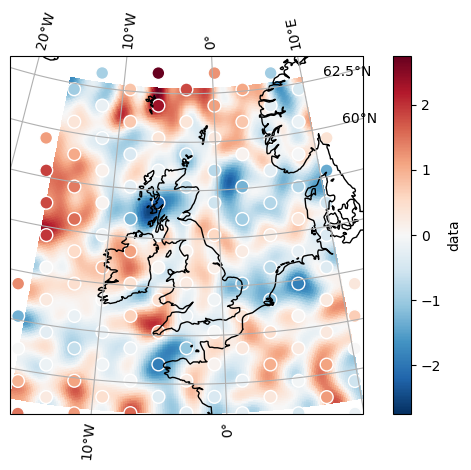

In [37]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": cartopy.crs.Stereographic(
    central_longitude=lon_origin, central_latitude=lat_origin,
)})

data_grid.plot(
    x="lon", y="lat", ax=ax, transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
)

data_points_agg.rename("data").to_dataset().plot.scatter(
    x="lon", y="lat", hue="data", s=85,
    ax=ax, transform=cartopy.crs.PlateCarree(),
)

ax.gridlines(draw_labels=True)            
ax.coastlines()

fig.tight_layout();

### Checking the difference

Note that xarray's [alignment](https://docs.xarray.dev/en/stable/generated/xarray.align.html) will match the aggregated point and grid data if we do arithmetics with both. So we can define a difference of the aggregated fiels just like this:

In [38]:
data_agg_diff = (
    abs(data_points_agg - data_grid_agg)
).rename("data_agg_diff")

Now, let's take a look:

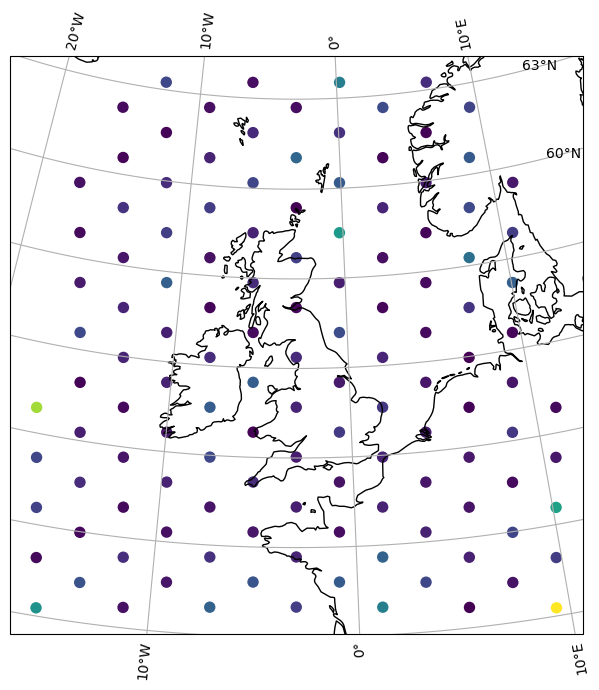

In [39]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Stereographic(
        central_longitude=lon_origin, central_latitude=lat_origin,
    )},
    figsize=(7, 7),
)

data_agg_diff.to_dataset().plot.scatter(
    x="lon", y="lat", hue="data_agg_diff", s=85,
    ax=ax, transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
)

ax.gridlines(draw_labels=True)            
ax.coastlines()

fig.tight_layout();

### Visualisation of the hexes

We can construct the corners of all hexes and then use Matplotlib's `plt.plot()` and `plt.fill()` to add hexes.

In [40]:
corners = hex_proj.hex_corners_lon_lat_xarray(data_agg_diff.hex_labels.compute())
corners

<xarray.Dataset>
Dimensions:     (hex_labels: 127, corner: 7)
Coordinates:
  * hex_labels  (hex_labels) object (-6, -2, 8) (-6, -1, 7) ... (6, -4, -2)
Dimensions without coordinates: corner
Data variables:
    lon         (corner, hex_labels) float64 -13.97 -14.32 -14.7 ... 12.1 12.65
    lat         (corner, hex_labels) float64 45.42 47.08 48.73 ... 50.01 51.64

We can use the corners dataset to plot hex outlines:

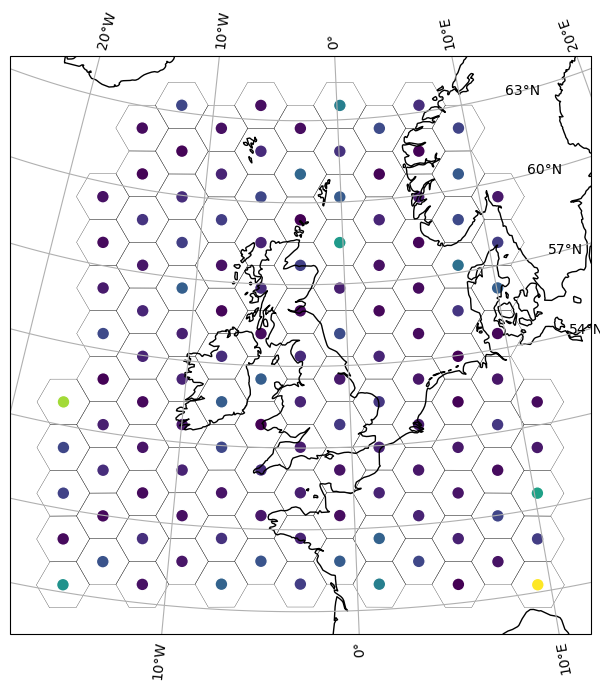

In [41]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Stereographic(
        central_longitude=lon_origin, central_latitude=lat_origin,
    )},
    figsize=(7, 7),
)

data_agg_diff.to_dataset().plot.scatter(
    x="lon", y="lat", hue="data_agg_diff", s=85,
    ax=ax, transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
)

# outlines are plotted here:
ax.plot(corners.lon, corners.lat, 'k-', linewidth=0.2, transform=cartopy.crs.PlateCarree());

ax.gridlines(draw_labels=True)            
ax.coastlines()

fig.tight_layout();

And we can also plot filled hexes:

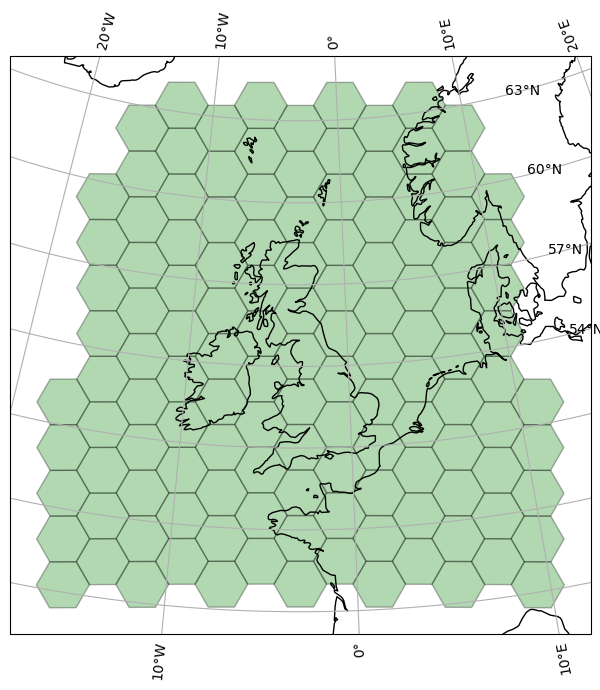

In [42]:
fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Stereographic(
        central_longitude=lon_origin, central_latitude=lat_origin,
    )},
    figsize=(7, 7),
)

# hexes are plotted here:
ax.fill(
    corners.lon, corners.lat, alpha=0.3, edgecolor="black", facecolor="green",
    transform=cartopy.crs.PlateCarree(), zorder=-1,
)

ax.gridlines(draw_labels=True)
ax.coastlines()

fig.tight_layout();